In [3]:
import pandas as pd
import re
import os
import glob
import snapatac2 as snap
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import seaborn as sns
import numpy as np
import utils
import subprocess

from pybedtools import BedTool
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_contents
from matplotlib_venn import venn2
#import pyBigWig

In [33]:
def merge_region(region='PFC',condition="MC",folder='/data2st1/junyi/output/atac0627/dar/region_nt/',method='mementob',blacklist=['Doublet','NN',"Neuron"]):
    df_result = pd.DataFrame()
    files = glob.glob(f'{folder}/{region}*{condition}_{method}.csv')
    for file in files:
        if any([file.find(black) > -1 for black in blacklist]):
            continue
        df_dar = pd.read_csv(file,index_col=0)

        ctname = file.split('/')[-1].replace('.csv', '')
        ctname = "_".join(ctname.split('_')[1:-2])
        if len(df_dar) == 0:
            continue
        df_dar['ctname'] = ctname
        df_result = pd.concat([df_result, df_dar], axis=0, ignore_index=True)
    df_result['region'] = region
    df_result['condition'] = condition
    return df_result

def intersect_bed_files(bed_file1, bed_file2):
    bed1 = BedTool(bed_file1)
    bed2 = BedTool(bed_file2)

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1
    bed2 = bed_file2

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

def get_proity_region(df_in, priority = [
    "promoter",
    "UTR",
    "exon",
    "intron",
    "intergenic"   ]

):
    df_in['annotation'] = priority[-1]
    df_in = df_in.loc[:,priority+['id']]
    priorityi = priority[::-1]
    for column in priorityi:
        df_in.loc[df_in[column]==True,"annotation"] = column
    return df_in


def is_promoter(row,interval_col="names"):
    # 解析第一个区间
    chrom_part, pos_part = row[interval_col].split(':')
    start1, end1 = map(int, pos_part.split('-'))
    strand = row['strand']

    if strand == "+":
        # 如果是正链，start1和end1不变
        # 获取第二个区间
        start2 = row['gstart']-2000
        end2 = row['gstart']
    else:
        strand = "-"
        start2 = row['gend']
        end2 = row['gend']+2000
    # 判断是否有交集
    return not (end1 < start2 or end2 < start1)

In [34]:
df_meta_dmr = pd.read_csv('/data1st2/hannan_25/data/Nanopore_processV1/nanopore_08_differential/summary/dmr_seg_anno_2tools_nofilter.csv')

In [35]:
# get coaccess regions
df_meta_dmr['anno_list'] = df_meta_dmr['anno'].str.split(' ')
df_coaccess = df_meta_dmr.explode('anno_list')
df_bed = pd.read_csv('/data1st2/hannan_25/data/Nanopore_processV1/nanopore_08_differential/summary/dmr_seg_anno_2tools_nofilter.bed', sep='\t', header=None)
df_bed.columns = ['chrom', 'start', 'end', 'id']
df_coaccess_regions = df_bed.merge(df_coaccess, left_on='id', right_on='anno_list', how='inner')
df_coaccess_regions['region'] = df_coaccess_regions['chrom']+":"+df_coaccess_regions['start'].astype(str)+"-"+df_coaccess_regions['end'].astype(str)
df_coaccess_regions['brainregion'] = df_coaccess_regions['comparision'].str.split('-').str[-1]
df_coaccess_regions['gender'] = df_coaccess_regions['comparision'].str[0]


In [36]:
method = 'mementob'
folder = '/data2st1/junyi/output/atac0627/darmr/All'
df_PFC_MC = merge_region(region='PFC',condition="MC",folder=folder,method=method)
df_PFC_MW = merge_region(region='PFC',condition="MW", folder=folder, method=method)
df_HIP_MC = merge_region(region='HIP',condition="MC",folder=folder,method=method)
df_HIP_MW = merge_region(region='HIP',condition="MW", folder=folder, method=method)
df_AMY_MC = merge_region(region='AMY',condition="MC",folder=folder,method=method)
df_AMY_MW = merge_region(region='AMY',condition="MW", folder=folder, method=method)
df_DAR_ALL = pd.concat([df_PFC_MC, df_PFC_MW, df_HIP_MC, df_HIP_MW, df_AMY_MC, df_AMY_MW], axis=0, ignore_index=True)

In [37]:
df_DAR_ALL = df_DAR_ALL.drop_duplicates(subset=['gene', 'region','condition'])

In [38]:
df_DAR_sign = df_DAR_ALL[df_DAR_ALL['de_pval'] <0.05]
df_DAR_sign.rename(columns={'region':'brainregion'}, inplace=True)
df_DAR_sign.rename(columns={'gene':'region'}, inplace=True)

/tmp/ipykernel_3878823/2228769891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DAR_sign.rename(columns={'region':'brainregion'}, inplace=True)
/tmp/ipykernel_3878823/2228769891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DAR_sign.rename(columns={'gene':'region'}, inplace=True)


In [39]:
df_meta_dmr['brainregion'] = df_meta_dmr['comparision'].str.split('-').str[-1]
df_meta_dmr['gender'] = df_meta_dmr['comparision'].str[0]
df_meta_dmr['region'] = "chr"+df_meta_dmr['dmr'].str.split('_').str[1]

In [40]:
# find the region only happen in female samples
df_meta_dmr_f = df_meta_dmr[df_meta_dmr['gender'] == 'F']
df_meta_dmr_m = df_meta_dmr[df_meta_dmr['gender'] == 'M']
region_f_only=(set(df_meta_dmr_f.region)).difference(set(df_meta_dmr_m.region))
df_DAR_sign_m = df_DAR_sign[~df_DAR_sign['region'].isin(region_f_only)]

In [41]:
df_meta_dmr_m['chrom'] = df_meta_dmr_m['region'].str.split(':').str[0]
df_meta_dmr_m['start'] = df_meta_dmr_m['region'].str.split(':').str[1].str.split('-').str[0].astype(int)
df_meta_dmr_m['end'] = df_meta_dmr_m['region'].str.split(':').str[1].str.split('-').str[1].astype(int)

/tmp/ipykernel_3878823/534532925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_dmr_m['chrom'] = df_meta_dmr_m['region'].str.split(':').str[0]
/tmp/ipykernel_3878823/534532925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_dmr_m['start'] = df_meta_dmr_m['region'].str.split(':').str[1].str.split('-').str[0].astype(int)
/tmp/ipykernel_3878823/534532925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [42]:
df_meta_dmr_m['related_dmr'] = df_meta_dmr_m['dmr']

/tmp/ipykernel_3878823/4272525037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_dmr_m['related_dmr'] = df_meta_dmr_m['dmr']


In [43]:
df_meta_dmr_m['region_type'] = 'DMR'

/tmp/ipykernel_3878823/2359097121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_dmr_m['region_type'] = 'DMR'


In [44]:
df_coaccess_regions_m = df_coaccess_regions[df_coaccess_regions['gender'] == 'M']
df_coaccess_regions_f = df_coaccess_regions[df_coaccess_regions['gender'] == 'F']
coaccess_f_only=(set(df_coaccess_regions_f.region)).difference(set(df_coaccess_regions_m.region))
#df_DAR_sign_m_coaccess = df_DAR_sign[~df_DAR_sign['region'].isin(coaccess_f_only)]
df_DAR_sign_m = df_DAR_sign_m[~df_DAR_sign_m['region'].isin(coaccess_f_only)]



In [45]:
df_coaccess_regions_m['related_dmr'] = df_coaccess_regions_m['dmr']
df_coaccess_regions_m['region_type'] = 'cCRE'

/tmp/ipykernel_3878823/33260877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaccess_regions_m['related_dmr'] = df_coaccess_regions_m['dmr']
/tmp/ipykernel_3878823/33260877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaccess_regions_m['region_type'] = 'cCRE'


In [46]:
df_coaccess_regions_m

,chrom,start,end,id,mod,motif,dmr,ifdifferent,score,num_sites,...,gene,comparision,tools,anno,anno_list,region,brainregion,gender,related_dmr,region_type
6,chr1,3205900,3671498,genebody_237_3205900:3671498,5mC,CG,5mC|CG_1:3241304-3241541,different,-26.329470,7,...,Xkr4,MC-PFC_vs_MW-PFC,methylDMR,genebody_237_3205900:3671498,genebody_237_3205900:3671498,chr1:3205900-3671498,PFC,M,5mC|CG_1:3241304-3241541,cCRE
13,chr1,4857813,4897909,genebody_147_4857813:4897909,5hmC,CG,5hmC|CG_1:4897510-4897657,different,-25.690201,7,...,Tcea1,MC-PFC_vs_MW-PFC,methylDMR,genebody_147_4857813:4897909,genebody_147_4857813:4897909,chr1:4857813-4897909,PFC,M,5hmC|CG_1:4897510-4897657,cCRE
15,chr1,4909575,5070285,genebody_50_4909575:5070285,5hmC,CG,5hmC|CG_1:4987699-4987749,different,22.136959,5,...,Rgs20,MC-AMY_vs_MW-AMY,methylDMR,genebody_50_4909575:5070285,genebody_50_4909575:5070285,chr1:4909575-5070285,AMY,M,5hmC|CG_1:4987699-4987749,cCRE
18,chr1,5307738,5310017,genebody_204_5307738:5310017,5hmC,CG,5hmC|CG_1:5308601-5308805,different,-25.484157,8,...,Gm37567,MC-TH_vs_MW-TH,methylDMR,genebody_204_5307738:5310017,genebody_204_5307738:5310017,chr1:5307738-5310017,TH,M,5hmC|CG_1:5308601-5308805,cCRE
19,chr1,6206196,6276648,genebody_66_6206196:6276648,5hmC,CG,5hmC|CG_1:6235008-6235074,different,-20.972923,6,...,Rb1cc1,MC-HIP_vs_MW-HIP,methylDMR,genebody_66_6206196:6276648,genebody_66_6206196:6276648,chr1:6206196-6276648,HIP,M,5hmC|CG_1:6235008-6235074,cCRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713769,chrY,90810671,90811793,coaccess_3_90810671:90811793,5mC,CH,5mC|CH_Y:90811383-90811386,different,47.449516,2,...,Gm47283,MC-PFC_vs_MW-PFC,modkit_fing,genebody_3_90784737:90816465 coaccess_3_908104...,coaccess_3_90810671:90811793,chrY:90810671-90811793,PFC,M,5mC|CH_Y:90811383-90811386,cCRE
713770,chrY,90810671,90811793,coaccess_3_90810671:90811793,5mC,CN,5mC|CN_Y:90811086-90811089,different,39.273202,3,...,Gm21860,MC-PFC_vs_MW-PFC,modkit_fing,coaccess_3_90810457:90811653 coaccess_3_908105...,coaccess_3_90810671:90811793,chrY:90810671-90811793,PFC,M,5mC|CN_Y:90811086-90811089,cCRE
713771,chrY,90810671,90811793,coaccess_3_90810671:90811793,5mC,CN,5mC|CN_Y:90811086-90811089,different,39.273202,3,...,Gm47283,MC-PFC_vs_MW-PFC,modkit_fing,genebody_3_90784737:90816465 coaccess_3_908104...,coaccess_3_90810671:90811793,chrY:90810671-90811793,PFC,M,5mC|CN_Y:90811086-90811089,cCRE
713772,chrY,90810671,90811793,coaccess_3_90810671:90811793,5mC,CN,5mC|CN_Y:90811383-90811386,different,47.288941,2,...,Gm21860,MC-PFC_vs_MW-PFC,modkit_fing,coaccess_3_90810457:90811653 coaccess_3_908105...,coaccess_3_90810671:90811793,chrY:90810671-90811793,PFC,M,5mC|CN_Y:90811383-90811386,cCRE


In [47]:
df_cCRE_m = df_coaccess_regions_m[['id','region','chrom','start','end','brainregion','related_dmr','region_type','mod','motif','gene','score','num_sites','case1_sig','case2_sig','effect_size','diff.Methy']]

In [48]:
df_DMR_m = df_meta_dmr_m[['dmr','region','chrom','start','end','brainregion','related_dmr','region_type','mod','motif','gene','score','num_sites','case1_sig','case2_sig','effect_size','diff.Methy']]

In [49]:
df_DMR_m.rename(columns={'dmr':'id'}, inplace=True)

/tmp/ipykernel_3878823/3271188164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DMR_m.rename(columns={'dmr':'id'}, inplace=True)


In [50]:
df_cCREdmr_m = pd.concat([df_cCRE_m, df_DMR_m], axis=0, ignore_index=True)

In [51]:
df_DAR_sign.rename(columns={'region':'brainregion'}, inplace=True)

/tmp/ipykernel_3878823/1290615773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DAR_sign.rename(columns={'region':'brainregion'}, inplace=True)


In [52]:
df_DAR_sign.rename(columns={'gene':'region'}, inplace=True)

/tmp/ipykernel_3878823/222015793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DAR_sign.rename(columns={'gene':'region'}, inplace=True)


In [53]:
df_cCREdmr_m.sort_values(by=['region'])

,id,region,chrom,start,end,brainregion,related_dmr,region_type,mod,motif,gene,score,num_sites,case1_sig,case2_sig,effect_size,diff.Methy
29416,genebody_233_100015629:100100416,chr10:100015629-100100416,chr10,100015629,100100416,HIP,5hmC|CG_10:100075460-100075693,cCRE,5hmC,CG,Kitl,-40.106254,9,0.189430,0.375824,-0.186394,-0.186394
29417,genebody_188_100015629:100100416,chr10:100015629-100100416,chr10,100015629,100100416,TH,5hmC|CG_10:100056176-100056364,cCRE,5hmC,CG,Kitl,29.293101,8,0.355386,0.183603,0.171783,0.171783
29418,coaccess_188_100055047:100056499,chr10:100055047-100056499,chr10,100055047,100056499,TH,5hmC|CG_10:100056176-100056364,cCRE,5hmC,CG,Cep290,29.293101,8,0.355386,0.183603,0.171783,0.171783
29419,coaccess_188_100055047:100056499,chr10:100055047-100056499,chr10,100055047,100056499,TH,5hmC|CG_10:100056176-100056364,cCRE,5hmC,CG,Kitl,29.293101,8,0.355386,0.183603,0.171783,0.171783
29420,coaccess_188_100055047:100056499,chr10:100055047-100056499,chr10,100055047,100056499,TH,5hmC|CG_10:100056176-100056364,cCRE,5hmC,CG,Tmtc3,29.293101,8,0.355386,0.183603,0.171783,0.171783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463420,5hmC|CN_Y:90812417-90812418,chrY:90812417-90812418,chrY,90812417,90812418,PFC,5hmC|CN_Y:90812417-90812418,DMR,5hmC,CN,Gm21860,25.791878,1,0.048300,0.201800,-0.144474,-0.153500
463068,5hmC|CH_Y:90812417-90812418,chrY:90812417-90812418,chrY,90812417,90812418,PFC,5hmC|CH_Y:90812417-90812418,DMR,5hmC,CH,Gm47283,25.791878,1,0.048300,0.201800,-0.144474,-0.153500
464176,5mC|CN_Y:90812417-90812418,chrY:90812417-90812418,chrY,90812417,90812418,PFC,5mC|CN_Y:90812417-90812418,DMR,5mC,CN,Gm21860,25.791878,1,0.000603,0.002048,-0.144474,-0.001445
464177,5mC|CN_Y:90812417-90812418,chrY:90812417-90812418,chrY,90812417,90812418,PFC,5mC|CN_Y:90812417-90812418,DMR,5mC,CN,Gm47283,25.791878,1,0.000603,0.002048,-0.144474,-0.001445


In [54]:
df_merge_dardmr = df_DAR_sign_m.merge(df_cCREdmr_m, left_on=['region','brainregion'], right_on=['region','brainregion'], how='inner', suffixes=('_dar', '_dmr'))

In [55]:
df_cCREdmr_m.groupby('brainregion').nunique()['region']

brainregion
AMY    33663
HIP    16371
PFC    21029
TH     24504
Name: region, dtype: int64

In [56]:
df_merge_dardmr.groupby('brainregion').nunique()['region']

brainregion
AMY    5558
HIP    2585
PFC    4132
Name: region, dtype: int64

In [57]:
df_cCREdmr_m

,id,region,chrom,start,end,brainregion,related_dmr,region_type,mod,motif,gene,score,num_sites,case1_sig,case2_sig,effect_size,diff.Methy
0,genebody_237_3205900:3671498,chr1:3205900-3671498,chr1,3205900,3671498,PFC,5mC|CG_1:3241304-3241541,cCRE,5mC,CG,Xkr4,-26.329470,7,0.271992,0.533276,-0.261284,-0.261284
1,genebody_147_4857813:4897909,chr1:4857813-4897909,chr1,4857813,4897909,PFC,5hmC|CG_1:4897510-4897657,cCRE,5hmC,CG,Tcea1,-25.690201,7,0.220291,0.414107,-0.193816,-0.193816
2,genebody_50_4909575:5070285,chr1:4909575-5070285,chr1,4909575,5070285,AMY,5hmC|CG_1:4987699-4987749,cCRE,5hmC,CG,Rgs20,22.136959,5,0.218870,0.104495,0.114375,0.114375
3,genebody_204_5307738:5310017,chr1:5307738-5310017,chr1,5307738,5310017,TH,5hmC|CG_1:5308601-5308805,cCRE,5hmC,CG,Gm37567,-25.484157,8,0.099323,0.247515,-0.148192,-0.148192
4,genebody_66_6206196:6276648,chr1:6206196-6276648,chr1,6206196,6276648,HIP,5hmC|CG_1:6235008-6235074,cCRE,5hmC,CG,Rb1cc1,-20.972923,6,0.078239,0.189594,-0.111356,-0.111356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464173,5mC|CN_Y:90812171-90812172,chrY:90812171-90812172,chrY,90812171,90812172,PFC,5mC|CN_Y:90812171-90812172,DMR,5mC,CN,Gm47283,29.577533,1,0.008279,0.005966,0.231244,0.002312
464174,5mC|CN_Y:90812265-90812272,chrY:90812265-90812272,chrY,90812265,90812272,PFC,5mC|CN_Y:90812265-90812272,DMR,5mC,CN,Gm21860,62.359259,4,0.007835,0.005770,0.206529,0.002065
464175,5mC|CN_Y:90812265-90812272,chrY:90812265-90812272,chrY,90812265,90812272,PFC,5mC|CN_Y:90812265-90812272,DMR,5mC,CN,Gm47283,62.359259,4,0.007835,0.005770,0.206529,0.002065
464176,5mC|CN_Y:90812417-90812418,chrY:90812417-90812418,chrY,90812417,90812418,PFC,5mC|CN_Y:90812417-90812418,DMR,5mC,CN,Gm21860,25.791878,1,0.000603,0.002048,-0.144474,-0.001445


Processing region: PFC


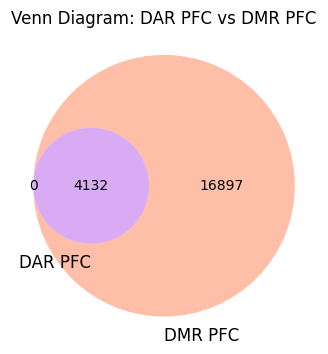

Processing region: HIP


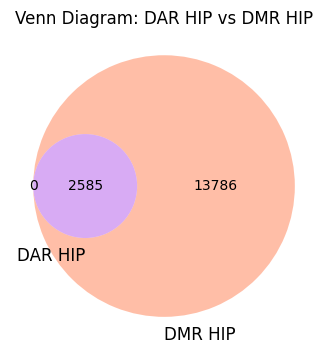

Processing region: AMY


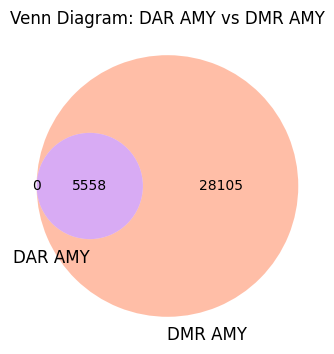

In [58]:
def draw_venn(df1, df2, title1, title2,column='gene'):
    set1 = set(df1[column])
    set2 = set(df2[column])
    venn_labels = {'10': len(set1 - set2), '01': len(set2 - set1), '11': len(set1 & set2)}
    plt.figure(figsize=(4, 4))
    venn2(subsets=venn_labels, set_labels=(title1, title2), alpha=0.5, set_colors=('blue', 'coral'))
    plt.title(f'Venn Diagram: {title1} vs {title2}')
    plt.show()

for brainregion in df_merge_dardmr.brainregion.unique():
    print(f'Processing region: {brainregion}')
    # filter df_region by de coefficient > 0.1
    df_region = df_merge_dardmr[df_merge_dardmr.brainregion == brainregion]
    #df_region = df_region[df_region['de_coef'].abs() > 0.8]
    df_deg_region = df_cCREdmr_m[df_cCREdmr_m.brainregion == brainregion]
    draw_venn(df_region, df_deg_region, f'DAR {brainregion}', f'DMR {brainregion}',column='region')

In [59]:
df_merge_dardmr.to_csv('/data2st1/junyi/output/atac0627/darmr/All/merge_dardmr_mementob.csv', index=False)

In [60]:
df_merge_dardmr

,region,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,brainregion,...,region_type,mod,motif,gene,score,num_sites,case1_sig,case2_sig,effect_size,diff.Methy
0,chrY:90737312-90739598,stim,0.352290,0.027405,8.080886e-38,-0.255209,0.098297,0.007492,All,PFC,...,cCRE,5hmC,CG,Gm21860,36.952983,1,0.674300,0.320000,0.350631,0.354300
1,chrY:90737312-90739598,stim,0.352290,0.027405,8.080886e-38,-0.255209,0.098297,0.007492,All,PFC,...,cCRE,5hmC,CN,Gm21860,36.952983,1,0.674300,0.320000,0.350631,0.354300
2,chrY:90737312-90739598,stim,0.352290,0.027405,8.080886e-38,-0.255209,0.098297,0.007492,All,PFC,...,cCRE,5mC,CG,Gm21860,36.952983,1,0.006743,0.003236,0.350631,0.003506
3,chrY:90737312-90739598,stim,0.352290,0.027405,8.080886e-38,-0.255209,0.098297,0.007492,All,PFC,...,cCRE,5mC,CN,Gm21860,36.952983,1,0.006743,0.003236,0.350631,0.003506
4,chrY:90737312-90739598,stim,0.352290,0.027405,8.080886e-38,-0.255209,0.098297,0.007492,All,PFC,...,cCRE,5hmC,CG,Gm21860,25.833819,1,0.766000,0.509400,0.239379,0.256600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60166,chrX:41794990-41920674,stim,-0.044748,0.022001,4.945459e-02,-0.042413,0.141792,0.846391,All,AMY,...,cCRE,5hmC,CG,Thoc2,27.894179,8,0.400664,0.177817,0.222847,0.222847
60167,chr14:20674307-20694852,stim,-0.042976,0.020757,4.970648e-02,-0.067971,0.099522,0.475241,All,AMY,...,cCRE,5hmC,CG,Sec24c,27.311805,7,0.338976,0.197229,0.141747,0.141747
60168,chr12:109541000-109571726,stim,-0.031795,0.015082,4.970716e-02,-0.048485,0.062323,0.302083,All,AMY,...,cCRE,5mC,CG,Meg3,70.054038,12,0.630346,0.442718,0.187628,0.187628
60169,chr13:35603029-35660777,stim,-0.080518,0.037941,4.993762e-02,0.372449,0.174244,0.043049,All,AMY,...,cCRE,5hmC,CG,Gm48707,-23.734029,5,0.031358,0.159083,-0.127725,-0.127725


In [62]:
adata_dmr = sc.read_h5ad('/data2st1/junyi/output/atac0627/3REGIONS_dmr.h5ads',backed='r')

/home/junyichen/anaconda3/envs/snapatac2/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [137]:
df_var = adata_dmr.var.copy()

In [140]:
df_var['region'] = df_var.index
df_var['is_first_occurrence'] = df_var.duplicated(subset='region', keep='first')

In [141]:
df_var

,region,is_first_occurrence
chr1:104983220-104983592,chr1:104983220-104983592,False
chr1:105344467-105344568,chr1:105344467-105344568,False
chr1:106226051-106226953,chr1:106226051-106226953,False
chr1:106299685-106299772,chr1:106299685-106299772,False
chr1:106299824-106299979,chr1:106299824-106299979,False
...,...,...
chrY:90810671-90811793,chrY:90810671-90811793,False
chrY:90810671-90811793,chrY:90810671-90811793,True
chrY:90810671-90811793,chrY:90810671-90811793,True
chrY:90810671-90811793,chrY:90810671-90811793,True


In [164]:
adata_dmr

AnnData object with n_obs × n_vars = 176318 × 213610 backed at '/data2st1/junyi/output/atac0627/3REGIONS_dmr.h5ads'
    obs: 'sample', 'doublet_probability', 'doublet_score', 'leiden', 'leiden_default', 'leiden_res_0.1', 'leiden_res_0.2', 'leiden_res_0.3', 'leiden_res_0.4', 'leiden_res_0.5', 'leiden_res_0.6', 'leiden_res_0.7', 'leiden_res_0.8', 'leiden_res_0.9', 'leiden_res_1.0', 'leiden_res_1.1', 'leiden_res_1.2', 'leiden_res_1.3', 'leiden_res_1.4', 'leiden_res_1.5', 'leiden_res_1.6', 'leiden_res_1.7', 'leiden_res_1.8', 'leiden_res_1.9', 'celltype.L2.Condition', 'celltype.L1', 'celltype.L2', 'Neurotransmitter_celltype', 'celltype.L1_ct', 'Sample_name', 'Condition', 'Region', 'celltype.L2.raw', 'region_nt', 'celltype.L3', 'celltype.L4'

In [148]:
adata = adata_dmr[:, df_var['is_first_occurrence']].to_memory()

/home/junyichen/anaconda3/envs/snapatac2/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [166]:
adata.layers['counts'] = adata_dmr[:, df_var['is_first_occurrence']].X.copy()

In [149]:
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)


In [150]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")


In [151]:
sc.tl.pca(adata)


In [152]:
sc.pp.neighbors(adata)


In [153]:
sc.tl.umap(adata)


In [4]:
adata = sc.read_h5ad('/data1st2/junyi/output/atac0627/3REGIONS_dmr_unique.h5ad')

/home/junyichen/anaconda3/envs/snapatac2/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [170]:
adata.write_h5ad('/data1st2/junyi/output/atac0627/3REGIONS_dmr_unique.h5ad')

In [ ]:
for brainregion in adata.obs.region.unique():
    adata_region = adata[adata.obs.region == brainregion]
    # filter df_region by de coefficient > 0.1
    calclu


AnnData object with n_obs × n_vars = 176318 × 56420
    obs: 'sample', 'doublet_probability', 'doublet_score', 'leiden', 'leiden_default', 'leiden_res_0.1', 'leiden_res_0.2', 'leiden_res_0.3', 'leiden_res_0.4', 'leiden_res_0.5', 'leiden_res_0.6', 'leiden_res_0.7', 'leiden_res_0.8', 'leiden_res_0.9', 'leiden_res_1.0', 'leiden_res_1.1', 'leiden_res_1.2', 'leiden_res_1.3', 'leiden_res_1.4', 'leiden_res_1.5', 'leiden_res_1.6', 'leiden_res_1.7', 'leiden_res_1.8', 'leiden_res_1.9', 'celltype.L2.Condition', 'celltype.L1', 'celltype.L2', 'Neurotransmitter_celltype', 'celltype.L1_ct', 'Sample_name', 'Condition', 'Region', 'celltype.L2.raw', 'region_nt', 'celltype.L3', 'celltype.L4'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'region_nt_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

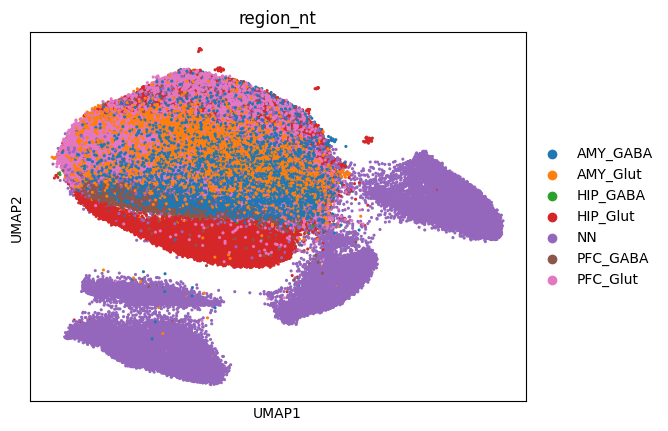

In [157]:
sc.pl.umap(
    adata,
    color="region_nt",
    # Setting a smaller point size to get prevent overlap
    size=20,
)
